# The Timeseries Quantum Autoencoder (TS unary encoding)
*TS QAE in Qiskit with unary encoding of TS sliding windows*

By: Jacob Cybulski<br>
Date: August 2023<br>
Aims: The goal of this tutorial is to build a Time Series Quantum Autoencoder, 
    a circuit which can compress a quantum state of a timeseries onto a smaller amount of qubits, 
    while retaining the information from the initial state.
Methods: A QAE model from Qiskit Tutorial 12 has been adopted for time series processing. 
- Time series data was converted to a series of sliding windows.
- Individual TS values were encoded in their binary representation.
- Amplitude encoding of TS windows was used, but was padded with zeros (0) to ensure the total number of values to be $2^n$.
- The model featuring an input and encoder blocks only (followed by a swap test) was subsequently trained.
- A decoder was then added for testing, and the circuit initialised with an optimum set of parameters from training.
- Each test sample was then encoded into the full QAE circuit, which was executed using a state vector simulation.
- State vectors of input and output data was then visualised and compared. 

Sources: 
1. Romero, Jonathan, Jonathan P. Olson, and Alan Aspuru-Guzik. 2017. “Quantum Autoencoders for Efficient Compression of Quantum Data.” Quantum Science and Technology 2 (4): 045001.
2. Qiskit Tutorial, https://qiskit.org/ecosystem/machine-learning/tutorials/12_quantum_autoencoder.html. *Based on [1].*
3. Eugenia Anello, Denoising Autoencoder in Pytorch on MNIST dataset, Dataseries (Medium), Jun 28, 2021.
4. Eugenia Anello, <a href="https://github.com/eugeniaring/Medium-Articles/blob/main/Pytorch/denAE.ipynb">GitHub</a>, Jun 28, 2021.
5. Phillip Lippe, Tutorial 9: Deep Autoencoders, UvA Deep Learning Tutorials, Fall 2022.

Notes:
- Refer to the end of the notebook for the log of changes

## The Quantum Autoencoder 

We can also define a quantum counterpart to the CAE, the Quantum Autoencoder. Much like the CAE, the Quantum Autoencoder aims to reduce the dimensionality of the input of the neural network, in this case a quantum state. A pictorial representation of this can be seen in Figure 2.

<div>
    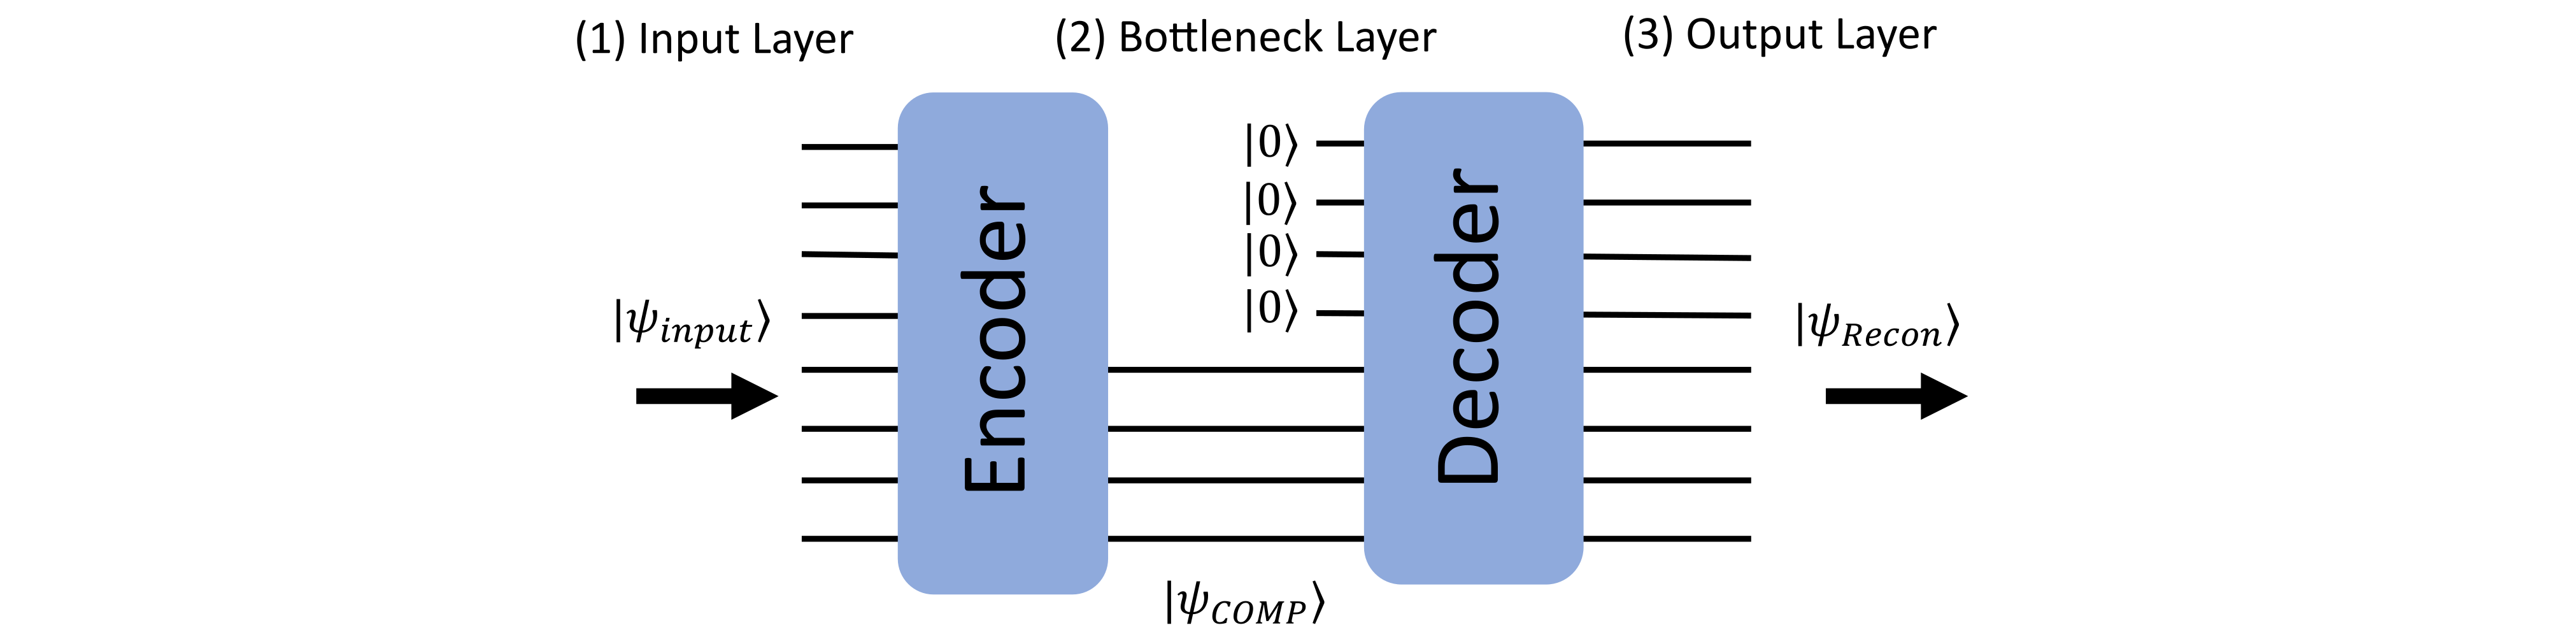
</div>
Pictorial Representation of a Quantum Autoencoder. Here one can see the similarities with the CAE, with the circuit having an input state, bottleneck state and an output state.

 

Much like its classical counterpart, our circuit contains three layers. We first input our state $|\psi>$ (which contains $n$ qubits), of which we wish to compress. This is our input layer (1). 

We then apply our parametrized circuit on our input state, which will act as our encoder and 'compresses' our quantum state, reducing the dimensionality of our state to $n-k$ qubits. Our new compressed state is of the form $|\psi_{comp}> \otimes |0>^{\otimes k}$, where $|\psi_{comp}>$ contains $n-k$ qubits. 

This parametrized circuit will depend on a set of parameters, which will be the nodes of our Quantum Autoencoder. Throughout the training process, these parameters will be updated to optimize the loss function. 

We disregard the remaining $k$ qubits for the remainder of the circuit. This is our bottleneck layer (2) and our input state is now compressed. 

The final layer consists of the addition of $k$ qubits (all in the state $|0\rangle$) and applying another parametrized circuit between the compressed state and the new qubits. This parametrized circuit acts as our decoder and reconstructs the input state from the compressed state using the new qubits. After the decoder, we retain the original state as the state travels to the output layer (3).

## Components of a Quantum Autoencoder

Before building our Quantum Autoencoder, we must note a few subtleties:
- We first note that we cannot introduce or disregard qubits in the middle of a Quantum Circuit when implementing an autoencoder using Qiskit.
- Because of this we must include our reference state as well as our auxiliary qubits (whose role will be described in later sections) at the beginning of the circuit.
- Therefore our QAE structure will consist of our input state, reference state and one auxiliary qubit, as well as a classical register to perform measurements.

## Choosing a Loss Function 

We now define our cost function, which we will use to train our Quantum Autoencoder, to return the input state. There's a bit of math involved here, so skip this section if you're not interested! 

We take the cost function as defined in [2], which tries to maximize the fidelity between the input and output state of our Quantum Autoencoder. 

We first define subsystems $A$ and $B$ to contain $n$ and $k$ qubits respectively, while $B'$ is the space which will contain our reference space. We call the subsystem $A$ our latent space, which will contain the compressed qubit state, and $B$ our trash space, which contain the qubits of which we disregard throughout compression. 

Our input state therefore $|\psi_{AB}>$ contains $n + k$ qubits. We define the reference space $B'$ which contains the reference state $|a>_{B'}$. This space will contain the additional $k$ qubits we use in the decoder. All of these subsystems can be seen in Figure 3. 

We define the parameterized circuit as $U(\theta)$ which we will use as our encoder. However the structure and parameters of our parametrized circuit is currently unknown to us and may vary for different input states. To determine the parameters to compress our input state, we must train our device to maximally compress the state by adjusting the values of the parameters $\theta$. For the decoder we will use $U^{\dagger}(\theta)$.

Our goal therefore is to maximize the fidelity between the input and output states, i.e.

$$\text{max }F(\psi_{AB}, \rho_{out})$$

where

$$\rho_{out} = U^{\dagger}(\theta)_{AB'} \text{Tr}_{B} [U(\theta)_{AB}[\psi_{AB} \otimes a_{B'}]U^{\dagger}(\theta)_{AB}]U(\theta)_{AB'}$$

We can maximize this fidelity by tuning the parameters $\theta$ in our parametrized circuit. However, this fidelity can at times be complicated to determine and may require a large amount of gates needed to calculate the fidelity between two states, i.e. the larger the number of qubits, the more gates required which results to deeper circuits.  Therefore we look for alternative means of comparing the input and output states. 

As shown in [2] a simpler way of determining an optimally compressed state is to perform a swap gate between the trash state and reference state. These states usually have a smaller number of qubits and are therefore easier to compare, due to the smaller amount of gates required. As shown in [2] maximizing the fidelity of such these two states is equivalent to maximizing the fidelity of the input and output state and thus determining an optimal compression of our input circuit. 

Keeping our reference state fixed, our cost function will now be a function of the trash state and is denoted as; 

$$\text{max }F(\text{Tr}_{A} [ U(\theta)_{AB}\psi_{AB} U^{\dagger}(\theta)_{AB}], a_{B'})$$

Throughout the training process, we adjust the parameters $\theta$ in our encoder and perform a swap test (as described below) to determine the fidelity between these trash and reference states. In doing so, we must include an additional qubit, our auxiliary qubit, which will be used throughout the swap test and measured to determine the overall fidelity of the trash and reference states. This is the reason why we included both an auxiliary qubit and classical register in the previous section when initializing our circuit.  

### The SWAP Test

The SWAP Test is a procedure commonly used to compare two states by applying CNOT gates to each qubit (for further information see [3]). By running the circuit $M$ times, and applying the SWAP test, we then measure the auxiliary qubit. We use the number of states in the state $|1\rangle$ to compute:

$$S = 1 - \frac{2}{M}L$$

where $L$ is the count for the states in the $|1\rangle$ state. As shown in [3], maximizing this function corresponds to the two states of which we are comparing being identical. We therefore aim to maximize this function, i.e. minimize  $\frac{2}{M}L$. This value will be therefore be our cost function.

## Initial settings

In [1]:
%%html
<style>
table {float:left}
</style>

In [2]:
pip list | grep -E 'qiskit|torch'

qiskit                        0.45.2
qiskit-aer-gpu                0.13.2
qiskit-algorithms             0.2.2
qiskit-dynamics               0.4.3
qiskit-finance                0.4.0
qiskit-ibm-provider           0.6.3
qiskit-ibm-runtime            0.11.3
qiskit-ibmq-provider          0.20.2
qiskit-machine-learning       0.7.1
qiskit-nature                 0.7.1
qiskit-optimization           0.6.0
qiskit-qasm3-import           0.4.1
qiskit-sphinx-theme           1.12.1
qiskit-terra                  0.45.2
torch                         2.1.0
torchaudio                    2.1.0
torchsummary                  1.5.1
torchvision                   0.16.0
Note: you may need to restart the kernel to use updated packages.


In [3]:
import sys
sys.path.append('.')
sys.path.append('..')
sys.path

['/home/jacob/Dropbox/Dev/Python/quantum_projects/ts/ts_denoise/qiskit_qae',
 '/home/jacob/miniconda3/envs/qiskit-gpu/lib/python310.zip',
 '/home/jacob/miniconda3/envs/qiskit-gpu/lib/python3.10',
 '/home/jacob/miniconda3/envs/qiskit-gpu/lib/python3.10/lib-dynload',
 '',
 '/home/jacob/miniconda3/envs/qiskit-gpu/lib/python3.10/site-packages',
 '.',
 '..']

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pylab
import math
from IPython.display import clear_output
%matplotlib inline

from utils.Target import *
from utils.Window import *
from utils.Callback import *

## Prepare windowed TS data
*Values need to be in [-100..+100] range*

### Prepare a time series

In [5]:
### Start random process
from qiskit.utils import algorithm_globals
algorithm_globals.random_seed = 2022

### Data settings
samples = 8*20
train_pc = 0.7
samples_train = int(np.round(samples * train_pc, 0))
samples_valid = samples - samples_train
samples_hi_res = samples*2

### Define the time series parameters
#   wind_size: sliding window size (which may be the same as number of qubits)
#   horizon:   the number of time events to look ahead (to forecast)
wind_size = 10
wind_step = 2
horizon = 1
scaler = 100
enc_digits = 12 # Includes 1 sign

### Select a target class and its parameters (see: utils.py), e.g.
#   Target_sin() # Target_2_sins() # Target_poly() # Target_poly_3()
#   Target_line() # Target_line(slope=0.5, intercept=0.2, xmin=0, xmax=1.5)
#   Target_trig_trend() # Target_jitter()
#   Target_beer() # Target_beer(pt_from=104, pt_to=156)

f = Target_2_sins()

### Define a target function params
lb, ub = f.xrange()
lb_train, ub_train = lb, lb+train_pc*(ub - lb)
lb_valid, ub_valid = lb+train_pc*(ub - lb), ub
eps = f.eps()
T = (ub - lb)

### Prepare all X and y data
X_all = np.linspace(lb, ub, num=samples_hi_res)
#y_all = f.fun(X_all)
y_all = [round(x*scaler, 0) for x in f.fun(X_all)]
X_all = [x for x in range(len(X_all))]

### Split data into windows
# Create windowed time series, ignore X units
# However, as the task is not predictive, so the horizon is ignored
X_train_ts, y_train_ts, X_valid_ts, y_valid_ts = ts_wind_split(
    ts_wind_make(X_all, wind_size, wind_step), 
    ts_wind_make(y_all, wind_size, wind_step), 
    train_pc)

### Show TS parameters
print(f'Selected Data\n')
print(f'Function: {f.name}, Eps: {f.eps()}')
print(f'Samples: {samples}, Split: {train_pc}, Train Samples: {samples_train}, Valid Samples: {samples_valid}')
print(f'Window Size: {wind_size}, Step: {wind_step}, Horizon: {horizon}')
print(f'Range: {(round(lb, 3), round(ub, 3))}')
print(f'Training Range: {(round(lb_train, 3), round(ub_train, 3))}')
print(f'Validation Range: {(round(lb_valid, 3), round(ub_valid, 3))}')
print(f'T: {(round(ub-lb, 3))}')
print()
print(f'Training Windows: {X_train_ts.shape[0]}, Validation Windows: {X_valid_ts.shape[0]}')

Selected Data

Function: Target_2_sins, Eps: 0.1
Samples: 160, Split: 0.7, Train Samples: 112, Valid Samples: 48
Window Size: 10, Step: 2, Horizon: 1
Range: (-6.283, 6.283)
Training Range: (-6.283, 2.513)
Validation Range: (2.513, 6.283)
T: 12.566

Training Windows: 109, Validation Windows: 47


/tmp/ipykernel_37323/3016747463.py:3: DeprecationWarning: The property ``qiskit.utils.algorithm_globals.QiskitAlgorithmGlobals.random_seed`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. This algorithm utility has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. You can run ``pip install qiskit_algorithms`` and import ``from qiskit_algorithms.utils`` instead. 
  algorithm_globals.random_seed = 2022


### Plot data

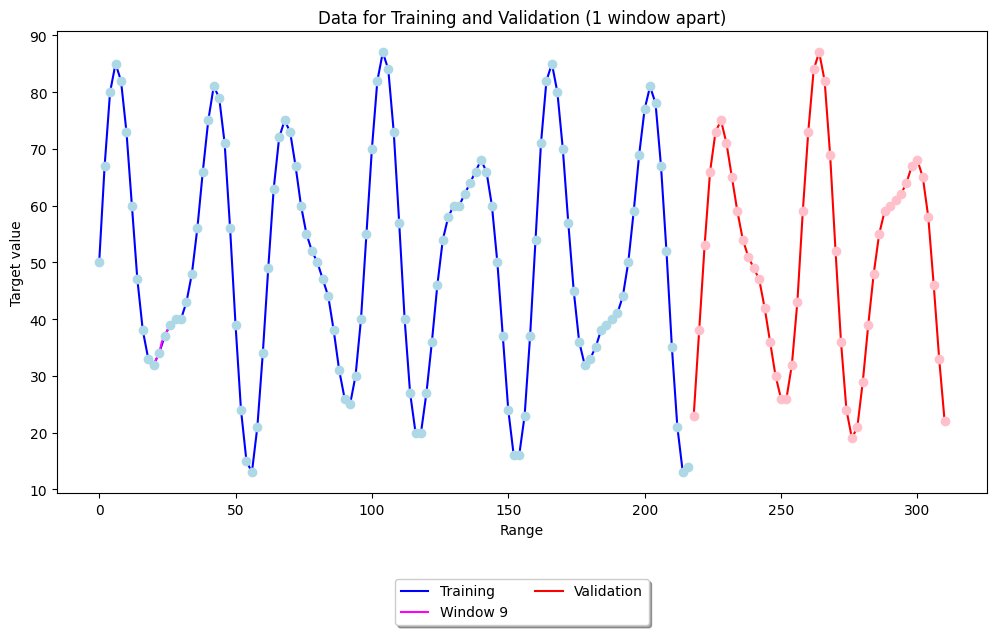



Sample Windows:

f([0,...,9]) ->
 [50.0, 59.0, 67.0, 74.0, 80.0, 83.0, 85.0, 85.0, 82.0, 78.0]
f([2,...,11]) ->
 [67.0, 74.0, 80.0, 83.0, 85.0, 85.0, 82.0, 78.0, 73.0, 67.0]
f([4,...,13]) ->
 [80.0, 83.0, 85.0, 85.0, 82.0, 78.0, 73.0, 67.0, 60.0, 54.0]
f([6,...,15]) ->
 [85.0, 85.0, 82.0, 78.0, 73.0, 67.0, 60.0, 54.0, 47.0, 42.0]
f([8,...,17]) ->
 [82.0, 78.0, 73.0, 67.0, 60.0, 54.0, 47.0, 42.0, 38.0, 35.0]



In [6]:
# Window to highlight
sel_wind = 9

# Plot prepared data
plt.rcParams["figure.figsize"] = (12, 6)
plt.title("Data for Training and Validation (1 window apart)")
plt.xlabel("Range")
plt.ylabel("Target value")
# plt.xlim(lb, ub)

# Plot target function
plt.plot([xt[0] for xt in X_train_ts], [y[0] for y in y_train_ts], color='blue', label='Training')
plt.plot(X_train_ts[sel_wind], y_train_ts[sel_wind], color='magenta', label='Window '+str(sel_wind))
plt.plot([xt[0] for xt in X_train_ts], [y[0] for y in y_train_ts], marker='o', color='lightblue', linestyle='None')
plt.plot([xv[0] for xv in X_valid_ts], [y[0] for y in y_valid_ts], color='red', label='Validation')
plt.plot([xv[0] for xv in X_valid_ts], [y[0] for y in y_valid_ts], marker='o', color='pink', linestyle='None')
# plt.plot(X_all, y_all, marker='o', color='lightblue', linestyle='None')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3),
          ncol=2, fancybox=True, shadow=True)
plt.show()

print(f'\n\nSample Windows:\n')
for i in range(5):
    print(f'f([{round(X_train_ts[i][0], 2)},...,{round(X_train_ts[i][-1], 2)}]) ->\n {[round(v, 2) for v in y_train_ts[i]]}')
print()

## Encoding TS windows
We can either quantize the TS values and rely on amplitude encoding (with RawFeatureVector),<br>
or we can use continuous TS values and utilize rotation encoding (with Z-Features or ZZ-Features).

Time series value quantization:
- The time series values will be mapped into a range of -100..+100
- Every value in the TS will be encoded relative to the previous value in terms of their difference
- The difference between values will be encoded into vn qubits, i.e. the sign and its bit representation
- The negative zero will be converted into an unsigned (positive) zero
- There are a few different ways of encoding the bit representation, e.g.
  
| Type | Example | No of Bits | Sign Location | Representation | Value Range |
| --- | :-: | :-: | :-: | --- | --- |
| Binary | -5 | 5 bits | bit 0 (right) | [0 1 0 1 1] | [-15, +15] |
| Unary | -5 | 8 bits | bit 0 (right) | [0 0 1 0 0 0 0 1] | [-7, +7] |


### Unary encoding

In [7]:
### Unary encoding of a TS value relative to the previous value
#   prev_raw: Previous value
#   next_raw: Next value
#   optional digits=8: Number of digits in representations, including sign
#   optional scaler=1: Number scaler 
#   returns: Encoding of the next value relative to the previous value in [-digits..+digits] range
#   error: when abs(next-prev) > digits, an error value is returned
def ts_reluna_encode_val(prev_raw, next_raw, digits=16, scaler=1):
    digits = digits-1 # Sign will be added later
    prev = int(round(prev_raw * scaler, 0))
    next = int(round(next_raw * scaler, 0))
    val = next-prev
    sign = 1 if val < 0 else 0
    val = np.abs(val)
    res = [0]*digits
    # print(f'res={res}, sign={sign}, digits={digits}, val={val}')
    
    if val > digits:
        print('*** Value out of range')
        res[digits-1] = 1
    elif val != 0:
        res[val-1] = 1
    return [sign]+res

### Decoding
def ts_reluna_decode_val(prev_raw, next_code, scaler=1):
    next_incr = 0
    sign = -1 if next_code[0] > 0.5 else 1
    for pos in range(len(next_code) - 1):
        next_incr += (pos+1)*next_code[pos+1]
    return prev_raw + sign*(next_incr / scaler)

### Normalises the value to 1 (esp. when fuzzy)
def ts_reluna_norm_val(next_code):
    norm_code = next_code
    sign = 1 if next_code[0] > 0.5 else 0
    val_total = np.sum(next_code[1:])
    if val_total != 0:
        for pos in range(len(next_code) - 1):
            norm_code[pos+1] = next_code[pos+1]/val_total
        norm_code[0] = sign
    return norm_code

### Print encoding and decoding for testing
def print_ts_reluna_encode_val(p, n, digits=16):
    print(f'{(p, n)} -> {ts_reluna_encode_val(p, n, digits=digits)}')
    
def print_ts_reluna_decode_val(p, n):
    print(f'{(p, n)} -> {ts_reluna_decode_val(p, n)}')

def print_ts_reluna_norm_val(p):
    p_org = [np.round(ip, 2) for ip in p]
    p_norm = [np.round(ip, 2) for ip in ts_reluna_norm_val(p)]
    print(f'{(p_org)} -> {p_norm}')


### Tests
print('Encoding:')
print_ts_reluna_encode_val(30, 30, digits=8)
print_ts_reluna_encode_val(30, 35, digits=8)
print_ts_reluna_encode_val(35, 30, digits=8)
print_ts_reluna_encode_val(30, 50, digits=8) # Incorrect
print_ts_reluna_encode_val(50, 30, digits=8) # Incorrect

print('\nDecoding:')
print_ts_reluna_decode_val(30, [0, 0, 0, 0, 0, 0, 0, 0])
print_ts_reluna_decode_val(30, [0, 0, 0, 0, 0, 1, 0, 0])
print_ts_reluna_decode_val(35, [1, 0, 0, 0, 0, 1, 0, 0])
print_ts_reluna_decode_val(30, [0, 0, 0, 0, 0, 0, 0, 1]) # Incorrect
print_ts_reluna_decode_val(50, [1, 0, 0, 0, 0, 0, 0, 1]) # Incorrect

print('\nFuzzy Decoding:')
print_ts_reluna_decode_val(30, [0, 0, 0, 0.5, 0, 0.5, 0, 0]) # 1.5 + 2.5
print_ts_reluna_decode_val(35, [0.6, 0, 0, 0.5, 0, 0.5, 0, 0]) # -(1.5 + 2.5)
print_ts_reluna_decode_val(30, [0.2, 0.2, 0.2, 0, 0.2, 0.2, 0, 0.2])

print('\nNormalise Encoding:')
print_ts_reluna_norm_val([0, 0, 0, 0, 0, 0, 0, 0])
print_ts_reluna_norm_val([0, 0, 0, 0.5, 0, 0.5, 0.3, 0.1])
print_ts_reluna_norm_val([0.6, 0, 0, 0.5, 0, 0.5, 0, 0])
print_ts_reluna_norm_val([0.2, 0.2, 0.2, 0, 0.2, 0.2, 0.2, 0.2])

Encoding:
(30, 30) -> [0, 0, 0, 0, 0, 0, 0, 0]
(30, 35) -> [0, 0, 0, 0, 0, 1, 0, 0]
(35, 30) -> [1, 0, 0, 0, 0, 1, 0, 0]
*** Value out of range
(30, 50) -> [0, 0, 0, 0, 0, 0, 0, 1]
*** Value out of range
(50, 30) -> [1, 0, 0, 0, 0, 0, 0, 1]

Decoding:
(30, [0, 0, 0, 0, 0, 0, 0, 0]) -> 30.0
(30, [0, 0, 0, 0, 0, 1, 0, 0]) -> 35.0
(35, [1, 0, 0, 0, 0, 1, 0, 0]) -> 30.0
(30, [0, 0, 0, 0, 0, 0, 0, 1]) -> 37.0
(50, [1, 0, 0, 0, 0, 0, 0, 1]) -> 43.0

Fuzzy Decoding:
(30, [0, 0, 0, 0.5, 0, 0.5, 0, 0]) -> 34.0
(35, [0.6, 0, 0, 0.5, 0, 0.5, 0, 0]) -> 31.0
(30, [0.2, 0.2, 0.2, 0, 0.2, 0.2, 0, 0.2]) -> 33.8

Normalise Encoding:
[0, 0, 0, 0, 0, 0, 0, 0] -> [0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0.5, 0, 0.5, 0.3, 0.1] -> [0, 0.0, 0.0, 0.36, 0.0, 0.36, 0.21, 0.07]
[0.6, 0, 0, 0.5, 0, 0.5, 0, 0] -> [1, 0.0, 0.0, 0.5, 0.0, 0.5, 0.0, 0.0]
[0.2, 0.2, 0.2, 0, 0.2, 0.2, 0.2, 0.2] -> [0, 0.17, 0.17, 0.0, 0.17, 0.17, 0.17, 0.17]


In [8]:
### Encoding the entire data set
def ts_reluna_encode(wind_set, digits=16, scaler=1):
    encoded_set = []
    for wind_idx in range(wind_set.shape[0]):
        wind = wind_set[wind_idx]
        encoded_wind = []
        prev = wind[0]
        for val_idx in range(wind.shape[0]):
            val = wind[val_idx]
            encoded_val = ts_reluna_encode_val(prev, val, digits, scaler)
            encoded_wind.append(encoded_val)
            prev = val
        encoded_set.append(encoded_wind)
    org_wind_start = np.array([w[0] for w in wind_set])
    return np.array(encoded_set), org_wind_start

### Encoding the entire data set
def ts_reluna_decode(org_wind_start, encoded_wind_set, scaler=1):
    decoded_set = []
    for wind_idx in range(encoded_wind_set.shape[0]):
        wind = encoded_wind_set[wind_idx]
        decoded_wind = []
        prev = org_wind_start[wind_idx]
        for val_idx in range(wind.shape[0]):
            encoded_val = wind[val_idx]
            decoded_val = ts_reluna_decode_val(prev, encoded_val, scaler)
            decoded_wind.append(decoded_val)
            prev = decoded_val
        decoded_set.append(decoded_wind)
    return np.array(decoded_set)

### Normalise the entire data set
def ts_reluna_norm(encoded_wind_set):
    norm_wind_set = []
    for wind_idx in range(encoded_wind_set.shape[0]):
        wind = encoded_wind_set[wind_idx]
        norm_wind = []
        for val_idx in range(wind.shape[0]):
            encoded_val = wind[val_idx]
            norm_val = ts_reluna_norm_val(encoded_val)
            norm_wind.append(norm_val)
        norm_wind_set.append(norm_wind)
    return np.array(norm_wind_set)

### Converting encoded windows into a list of circuit parameters by padding them to fit amplitude encoding
def ts_reluna_wind2params(enc_set, padding):
    wind_bits = enc_set[0].shape[0] * enc_set[0].shape[1]
    ts_params = [list(np.reshape(enc_wind, (wind_bits, ))) + [0]*padding for enc_wind in enc_set]
    return np.array(ts_params)

### Converting list of circuit parameters to encoded windows by removing padding
def ts_reluna_params2wind(params, padding):
    flat_windows = list([param[:-padding] for param in params])
    return np.reshape(flat_windows, (len(params), wind_size, enc_digits))

### Preparing data for training

In [9]:
y_train_enc, org_train_start = ts_reluna_encode(y_train_ts, digits=enc_digits)

### Testing
# y_train_dec = ts_reluna_decode(org_train_start, ts_reluna_norm(y_train_enc))
# print('Training windows before encoding:\n', y_train_ts[5:8])
# print('\nTraining windows after encoding:\n', y_train_enc[5:8])
# print('\nTraining windows org start:\n', org_train_start[5:8])
# print('\nTraining windows after decoding:\n', y_train_dec[5:8])

In [10]:
wind_bits = wind_size * enc_digits
wind_qubits = int(np.ceil(np.log2(wind_bits)))
wind_padding = 2**wind_qubits - wind_bits

print(f'Trainig TS windows properties\n')
print(f'Each TS window has {wind_size} values, e.g. y_train_ts[6]={[int(x) for x in y_train_ts[6]]}')
print(f'Each signed TS value is encoded as {enc_digits} bits, e.g. y_train_ts[6][9]={int(y_train_ts[6][9])}-{int(y_train_ts[6][8])}={y_train_enc[6][9]}')
print(f'Each TS window has {wind_bits} bits, e.g. y_train_enc[6]:\n{y_train_enc[6]}')
print(f'Each TS window requires {wind_qubits} qubits to encode with amplitude encoding')
print(f'Each TS window parameters require window padding with extra {wind_padding} bits')
# print(f'Example of parameter padding for y_train_ts[6] ->')
# print(f' {list(np.reshape(y_train_enc[6], (wind_bits, )))} + {[0]*wind_padding} =')
# print(f' {list(ts_relbin_wind2params(y_train_enc[6:7], wind_padding)[0])}')
# print(f'\nSample of padded window parameters y_train_enc[5:8]:')
# params_sample = ts_relbin_wind2params(y_train_enc[5:8], wind_padding)
# for param in params_sample:
#     print(f' {list(param)}')

Trainig TS windows properties

Each TS window has 10 values, e.g. y_train_ts[6]=[60, 54, 47, 42, 38, 35, 33, 32, 32, 33]
Each signed TS value is encoded as 12 bits, e.g. y_train_ts[6][9]=33-32=[0 1 0 0 0 0 0 0 0 0 0 0]
Each TS window has 120 bits, e.g. y_train_enc[6]:
[[0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 1 0 0 0 0 0]
 [1 0 0 0 0 0 0 1 0 0 0 0]
 [1 0 0 0 0 1 0 0 0 0 0 0]
 [1 0 0 0 1 0 0 0 0 0 0 0]
 [1 0 0 1 0 0 0 0 0 0 0 0]
 [1 0 1 0 0 0 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0]]
Each TS window requires 7 qubits to encode with amplitude encoding
Each TS window parameters require window padding with extra 8 bits


## Building and training a Quantum Autoencoder

First, we implement IBM's Qiskit to build our Quantum Autoencoder. We first begin by importing in the necessary libraries and fixing the seed.

In [11]:
import json
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import ClassicalRegister, QuantumRegister
from qiskit import QuantumCircuit
from qiskit_algorithms.optimizers import COBYLA, NELDER_MEAD
from qiskit.circuit.library import RealAmplitudes, ZFeatureMap, ZZFeatureMap
from qiskit.quantum_info import Statevector
from qiskit.utils import algorithm_globals
from qiskit.visualization import plot_histogram, plot_state_city, plot_state_paulivec

from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit_machine_learning.neural_networks import SamplerQNN

algorithm_globals.random_seed = 42

/tmp/ipykernel_37323/1414363119.py:19: DeprecationWarning: The property ``qiskit.utils.algorithm_globals.QiskitAlgorithmGlobals.random_seed`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. This algorithm utility has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. You can run ``pip install qiskit_algorithms`` and import ``from qiskit_algorithms.utils`` instead. 
  algorithm_globals.random_seed = 42


### Selection of an ansatz

The selectede ansatz is the Qiskit RealAmplitude ansatz (2-local circuit) - the prepared quantum states will only have real amplitudes, and does not rely on full connectivity between qubits. 

In [12]:
def ansatz(num_qubits, reps=4, ent='circular'):
    return RealAmplitudes(num_qubits, reps=reps, entanglement=ent)

Let's draw this ansatz with $n+k$ qubits and see what it looks like.

/home/jacob/miniconda3/envs/qiskit-gpu/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


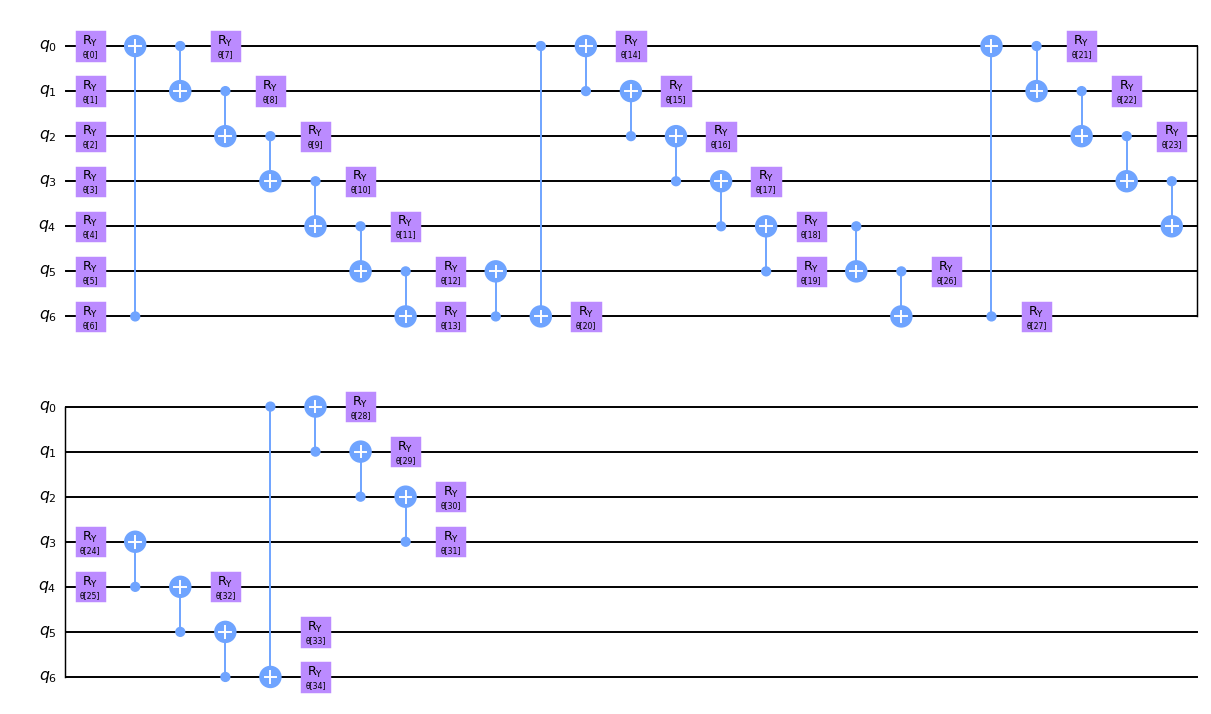

Number of ansatz parameters: 35



In [13]:
circ = ansatz(wind_qubits, reps=4, ent='sca') # linear, reverse_linear, full, circular, sca
display(circ.decompose().draw("mpl", scale=0.7))
print(f'Number of ansatz parameters: {len(circ.parameters)}\n')

### Encoder development
We now apply the ansatz as an Encoder to the state we wish to compress. 
We divide our initial $n+k$ qubit state into a $n$ qubit latent state and $k$ qubit trash space. 
We must also include a $k$ qubit reference space in our circuit, as well as $1$ auxiliary qubit to perform the swap test between the reference and trash states. 
We will therefore have a total of $n + k + k + 1$ qubits and $1$ classical register in our circuit.

After initializing our state, we apply our parametrized circuit.

Following this, we then split our initial state into the latent space (the compressed state) and trash space (the part of the state we will disregard) 
and perform the swap test between the reference state and the trash space. 
The last qubit is then measured to determine the fidelity between the reference and trash states.  
A pictorial representation of this is given below in the following figure. 

<div>
    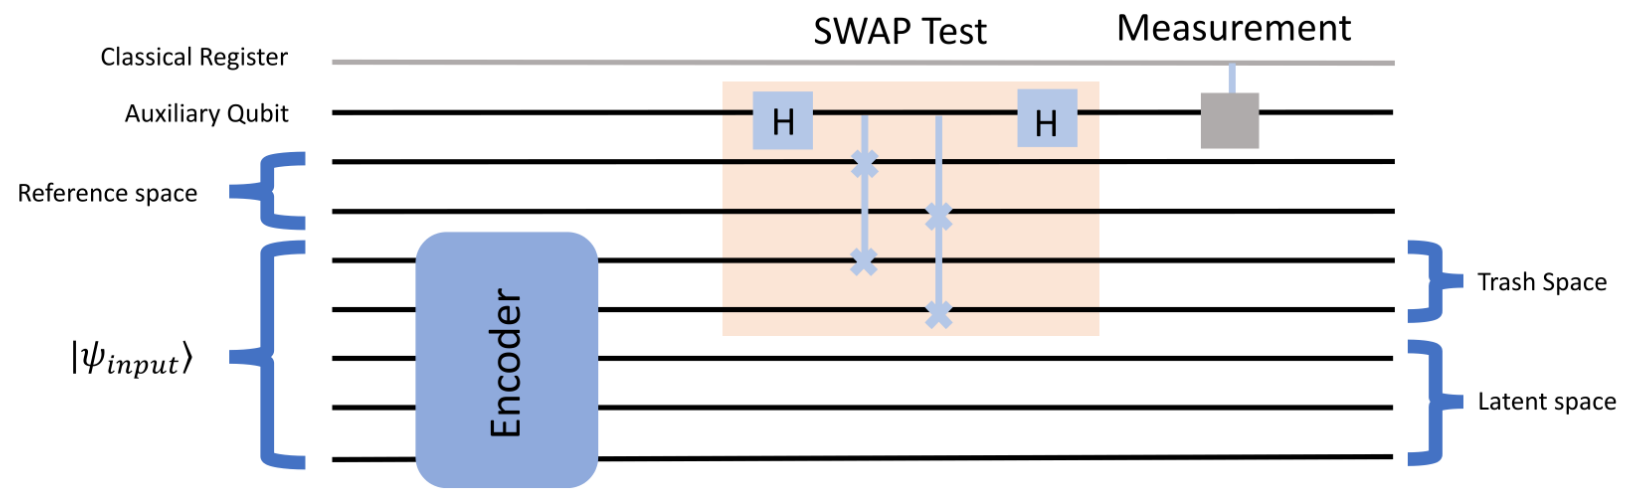
</div>

Figure: Example of a Quantum Autoencoder in the training process. We use the swap test to determine the fidelity between the trash and reference space. 

We define a function below to implement the above circuit configuration to the $5$ qubit domain wall state $|00111\rangle$ and plot an example below. Here qubits $5$ and $6$ are the reference state, $0, 1, 2, 3, 4$ are the initial state we wish to compress and qubit $7$ is our auxiliary qubit which is used in the swap test. We also include a classical register to measure the results of qubit $7$ in the swap test. 

In [14]:
num_trash = 2
num_latent = wind_qubits-num_trash

/home/jacob/miniconda3/envs/qiskit-gpu/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


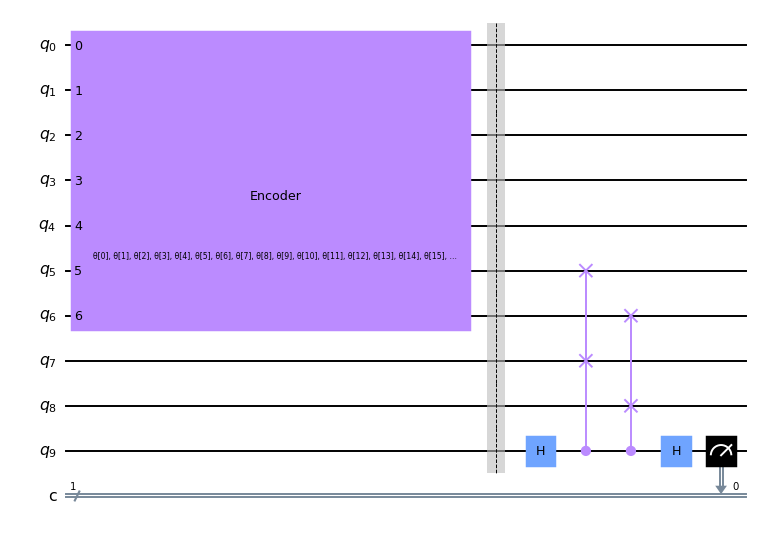

Number of trash qubits k=2
Number of latent qubits n=5



In [15]:
def auto_encoder_circuit(num_latent, num_trash, reps=4, ent='circular'):
    qr = QuantumRegister(num_latent + 2 * num_trash + 1, "q")
    cr = ClassicalRegister(1, "c")
    anz = ansatz(num_latent + num_trash, reps=reps, ent=ent)
    anz.name = 'Encoder'
    circuit = QuantumCircuit(qr, cr)
    circuit.compose(anz, range(0, num_latent + num_trash), inplace=True)
    circuit.barrier()
    auxiliary_qubit = num_latent + 2 * num_trash
    # swap test
    circuit.h(auxiliary_qubit)
    for i in range(num_trash):
        circuit.cswap(auxiliary_qubit, num_latent + i, num_latent + num_trash + i)

    circuit.h(auxiliary_qubit)
    circuit.measure(auxiliary_qubit, cr[0])
    return circuit

circuit = auto_encoder_circuit(num_latent, num_trash)
display(circuit.draw("mpl", scale=0.7))
print(f'Number of trash qubits k={num_trash}')
print(f'Number of latent qubits n={num_latent}\n')

In order to reconstruct the original input state, we must apply the adjoint of our parametrized circuit after the swap test.<br>
However, during training, we are only interested in the trash state and the reference state.<br>
We can therefore exclude the gates following compression until we wish to reconstruct our initial input. 

After building our Quantum Autoencoder, the next step is to train our Quantum Autoencoder to compress the state and maximize the cost function and determine the parameters $\theta$. 

### Building a full quantum encoder
After encoding our TS windows into $(n+k)$ qubits, we begin to train our Quantum Autoencoder to compress this state into $k$ qubits.<br>
We will write a cost function based on the Swap Test between the trash and latent space.<br>
Note that the input state and trash space contain the same amount of qubits. 

Let's input one of our windows and see our circuit for the Autoencoder below. 

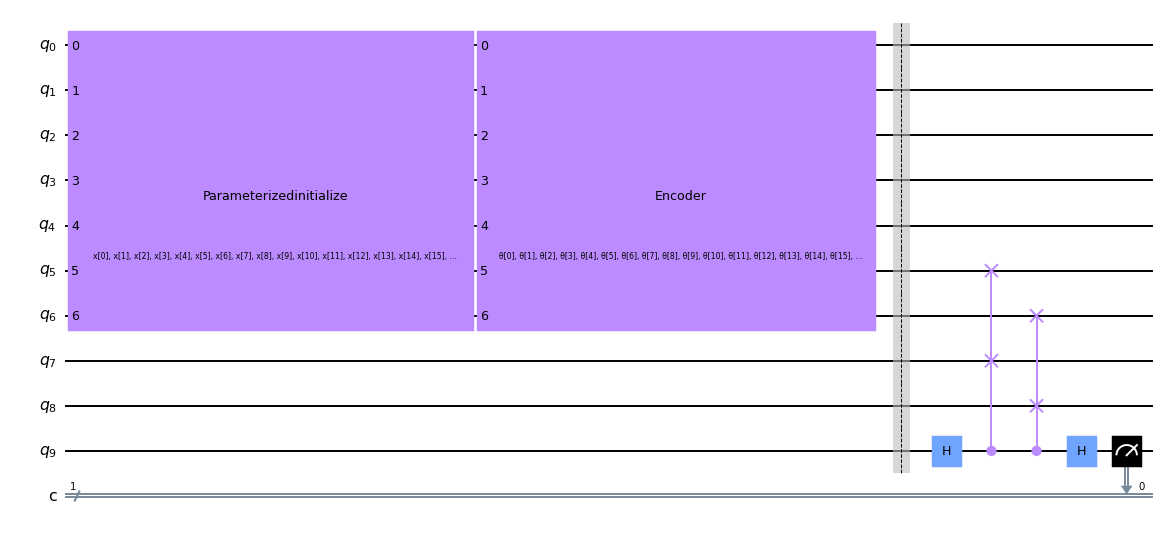

#Inputs: 128 (109, 128)
#Weights: 35



In [16]:
reps=4
ent='sca' # linear, reverse_linear, full, circular, sca
fm = RawFeatureVector(2 ** (num_latent + num_trash))
ae = auto_encoder_circuit(num_latent, num_trash, reps=reps, ent=ent)
wind_train_params = ts_reluna_wind2params(y_train_enc, wind_padding)

qc = QuantumCircuit(num_latent + 2 * num_trash + 1, 1)
qc = qc.compose(fm, range(num_latent + num_trash))
qc = qc.compose(ae)

display(qc.draw("mpl", scale=0.7))
print('#Inputs:', len(fm.parameters), wind_train_params.shape)
print('#Weights:', len(ae.parameters))
print()

Again, we can see the swap test being performed on the selected qubits to determine the value of our cost function.

## Model training

**Sampler** needs to be imported from *qiskit_aer.primitives*.
Unfortunately, *qiskit-aer-gpu 0.12.2* has a bug, which has been fixed 
in the next version *qiskit-aer-gpu 0.13.0*, see notes in the version table.

In [30]:
from qiskit.primitives import Sampler # This sampler ignores device="GPU" option
seed = 2023
sampler = Sampler()
sampler.set_options(method='statevector')
sampler.set_options(device='CPU')
sampler.set_options(seed=seed)
sampler.options

Options(method='statevector', device='CPU', seed=2023)

In [31]:
# from qiskit_aer.primitives import Sampler as AerSampler # This sampler will accept device="GPU" option
# seed = 2023
# sampler = AerSampler(
#     backend_options={'method':'statevector', 'device' : 'GPU', 'cuStateVec_enable' : True},
#     run_options={'seed': seed, 'shots': 1024},
#     transpile_options={"seed_transpiler": seed},
# )

In [32]:
def identity_interpret(x):
    return x

first_only = lambda x: x % 2

qnn = SamplerQNN(
    circuit=qc,
    input_params=fm.parameters,
    weight_params=ae.parameters,
    interpret=identity_interpret,
    output_shape=2,
    sampler=sampler
)

We build our cost function, based on the swap test between the reference and trash space for the digit dataset. To do this, we again use Qiskit's CircuitQNN network and use the same interpret function as we are measuring the probability of getting the final qubit in the $|1\rangle$ state.

In [33]:
def cost_func_tswind(params_values):
    probabilities = qnn.forward(wind_train_params, params_values)
    cost = np.sum(probabilities[:, 1]) / wind_train_params.shape[0]

    # plotting part
    clear_output(wait=True)
    objective_func_vals.append(cost)
    plt.title("Cost function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Cost function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

    return cost

Since model training may take a long time we have already pre-trained the model for some iterations and saved the pre-trained weights. We'll continue training from that point by setting `initial_point` to a vector of pre-trained weights.

In [34]:
print('#Inputs:', len(fm.parameters), wind_train_params.shape)
print('#Weights:', len(ae.parameters))
print()

#Inputs: 128 (109, 128)
#Weights: 35



In [35]:
saved_starting_point = False
init_file_name = f'qae_unary_{ent}_reps{reps}_p{len(ae.parameters)}_init.json'

if saved_starting_point:
    ### Using previously saved init point
    print(f'Using previously saved init parameters from file "{init_file_name}"')
    epochs = 50 
    with open(init_file_name, 'r') as f:
        initial_point = json.load(f)
else:
    ### Using a random init point
    print(f'Random init parameters to be saved to file "{init_file_name}"')
    epochs = 500 # 200 
    initial_point = algorithm_globals.random.random(ae.num_parameters)

Random init parameters to be saved to file "qae_unary_sca_reps4_p35_init.json"


/tmp/ipykernel_37323/161566824.py:14: DeprecationWarning: The property ``qiskit.utils.algorithm_globals.QiskitAlgorithmGlobals.random`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. This algorithm utility has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. You can run ``pip install qiskit_algorithms`` and import ``from qiskit_algorithms.utils`` instead. 
  initial_point = algorithm_globals.random.random(ae.num_parameters)


By minimizing this cost function, we can thus determine the required parameters to compress our noisy images. Let's see if we can encode our images! 

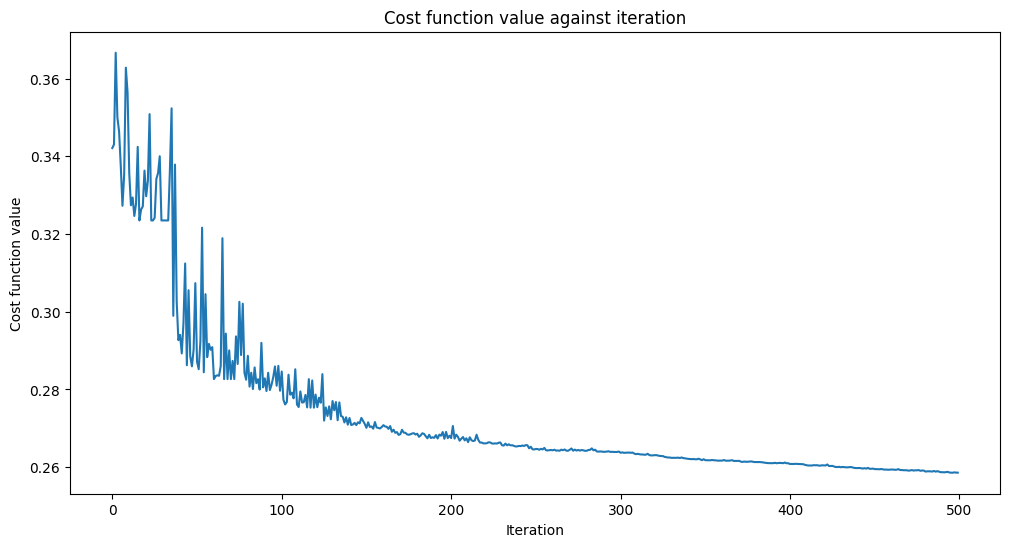

Fit in 285.51 seconds


In [36]:
opt = COBYLA(maxiter=epochs)

objective_func_vals = []
# make the plot nicer
plt.rcParams["figure.figsize"] = (12, 6)

start = time.time()
opt_result = opt.minimize(fun=cost_func_tswind, x0=initial_point)
elapsed = time.time() - start
print(f"Fit in {elapsed:0.2f} seconds")

In [37]:
to_be_saved_starting_point = True

if to_be_saved_starting_point:
    ## Saving the initialisation point
    with open(init_file_name, 'w') as f:
        json.dump(opt_result.x.tolist(), f)
    print(f'Saved optimum parameters as the future starting point, in: {init_file_name}')

Saved optimum parameters as the future starting point, in: qae_unary_sca_reps4_p35_init.json


Looks like the training converged, but not very well - expected final cost below 0.05!

**<font color='red'>However, it still needs to be tested to check if it makes any sense!</font>**

## Model testing

### Preparing data for testing

In [38]:
### Encoding all test windows
y_valid_enc, org_valid_start = ts_reluna_encode(y_valid_ts, digits=enc_digits)

In [39]:
### Testing validation windows

# y_valid_dec = ts_reluna_decode(org_valid_start, y_valid_enc)

# print('Validation windows before encoding:\n', y_valid_ts[5:8])
# print('\nValidation windows after encoding:\n', y_valid_enc[5:8])
# print('\nValidation windows org start:\n', org_valid_start[5:8])
# print('\nValidation windows after decoding:\n', y_valid_dec[5:8])

# params_sample = ts_reluna_wind2params(y_valid_enc[5:8], wind_padding)
# winds_recovered = ts_reluna_params2wind(params_sample, wind_padding)

# print(f'\nSample of padded window parameters y_valid_enc[5:8]:')
# for param in params_sample:
#     print(f' {list(param)}')
# print(f'\nValidation windows after recovery:\n{winds_recovered}\n')

# print(f'\nNumber of validation windows: {y_valid_dec.shape[0]}')

## Model testing

### Building a full QAE
Now let's build our Encoder and Decoder using the parameters obtained from the training period.<br>
After applying this circuit to our new dataset, we can then compare our input and output data.<br>
We will be able to see if we were able to retain the TS efficiently throughout the compression! 

/home/jacob/miniconda3/envs/qiskit-gpu/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


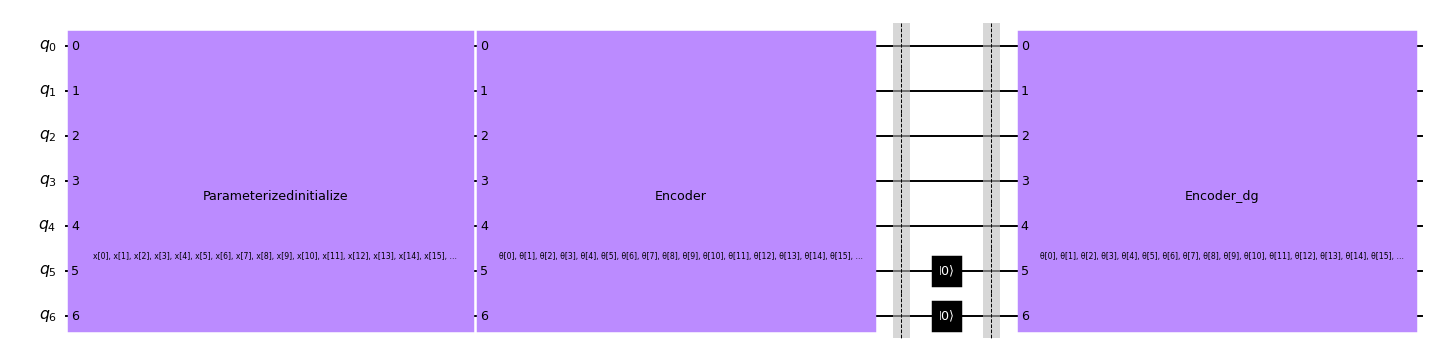

In [40]:
# Test
test_qc = QuantumCircuit(num_latent + num_trash)
test_qc = test_qc.compose(fm)
ansatz_qc = ansatz(num_latent + num_trash, reps=reps, ent=ent)
ansatz_qc.name = 'Encoder'
test_qc = test_qc.compose(ansatz_qc)
test_qc.barrier()

for i in range(num_trash):
    test_qc.reset(num_latent + i)

test_qc.barrier()
ansatz_inv_qc = ansatz_qc.inverse()
test_qc = test_qc.compose(ansatz_inv_qc)
display(test_qc.draw(output='mpl', scale=0.7, fold=False))

### Running and analysing tests for the selected TS windows


Window 1:



Input SV data (sum=1.0, max=0.111 at index=19, shape=(10, 12)):
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

Output SV data (sum=1.0, max=0.119 at index=53, shape=(10, 12)):
[[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.028 0.051 0.02  0.084 0.171 0.495 0.799 0.761 0.002 0.23 ]
 [0.005 0.004 0.015 0.008 0.002 0.013 0.002 0.008 0.005 0.   ]
 [0.01  0.001 0.003 0.    0.    0.004 0.024 0.006 0.001 0.002]
 [0.136 0.228 0.004 0.287 0.    0.013 0.028 0.018 0.003 0.   ]
 [0.358 0.646 0.837 0.48  0.618 0.014 0.001 0.172 0.448 0.37 ]
 [0.01  0.01  0.    0.005 0.    0.001 0.001 0.001 0.005 0.005]
 [0.001 0.012 0.00

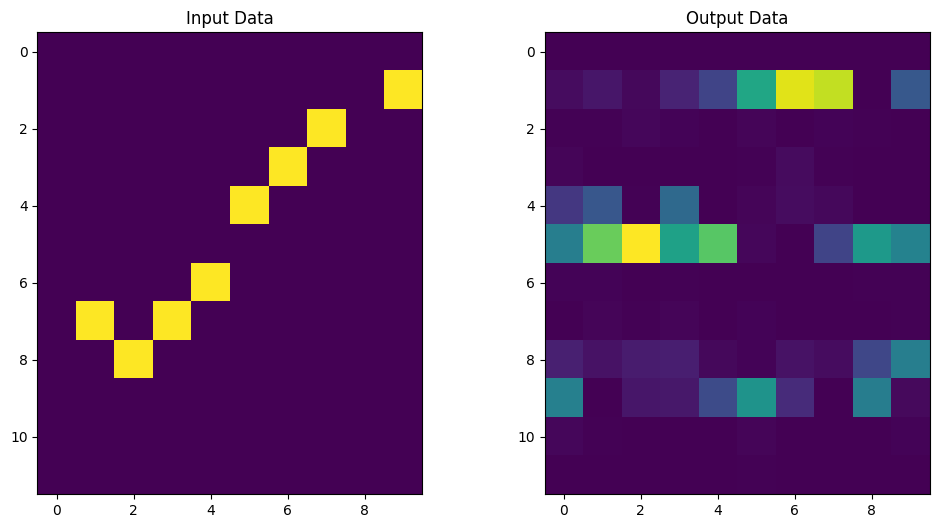


Window 2:



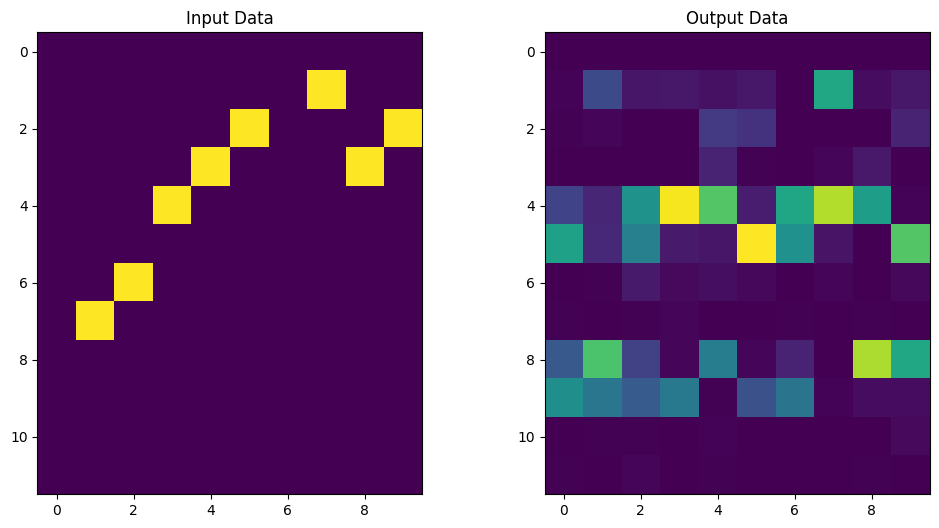


Window 3:



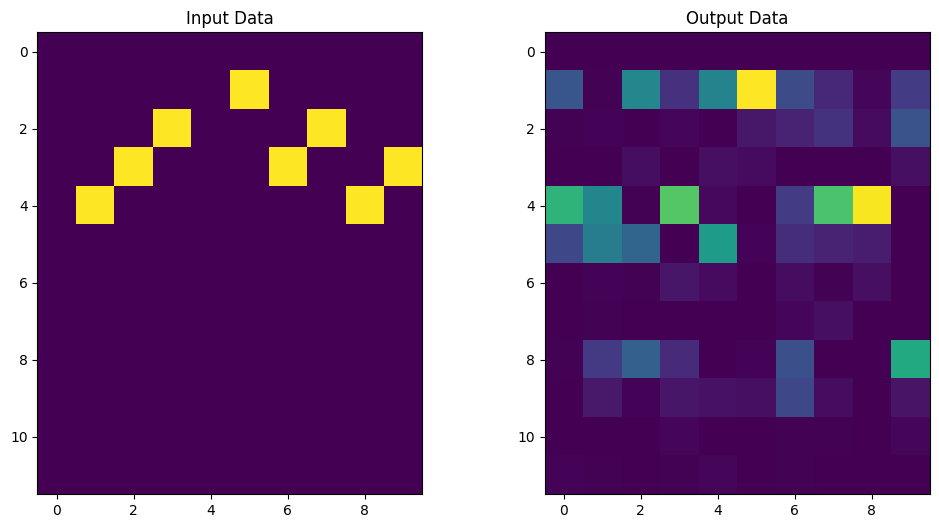


Window 4:



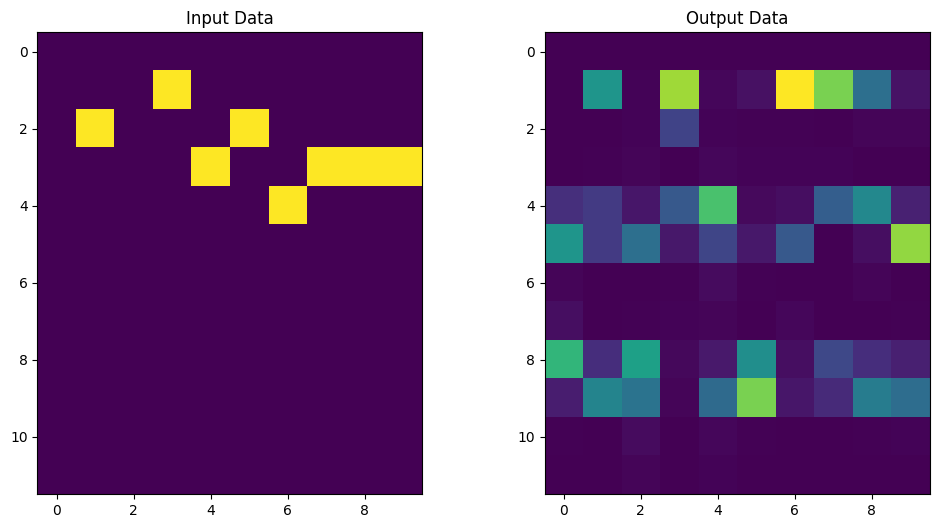


Window 5:



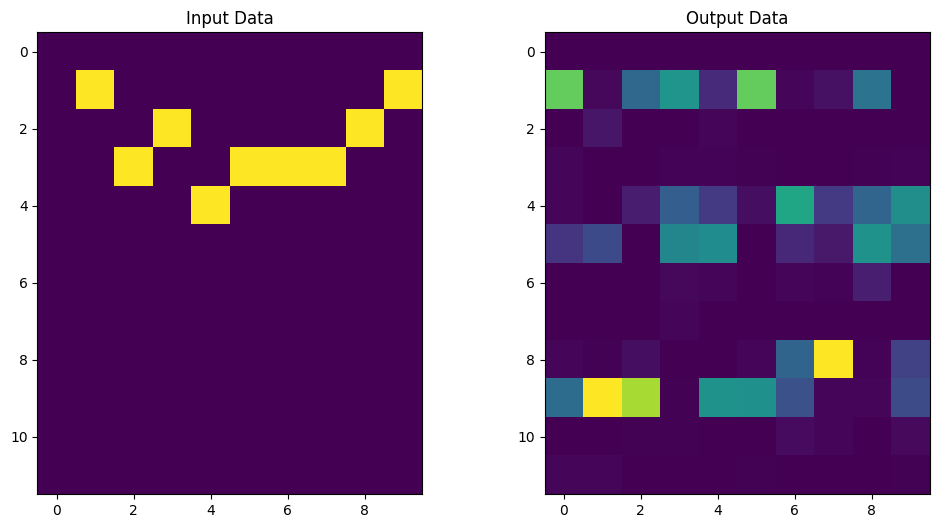


Window 10:



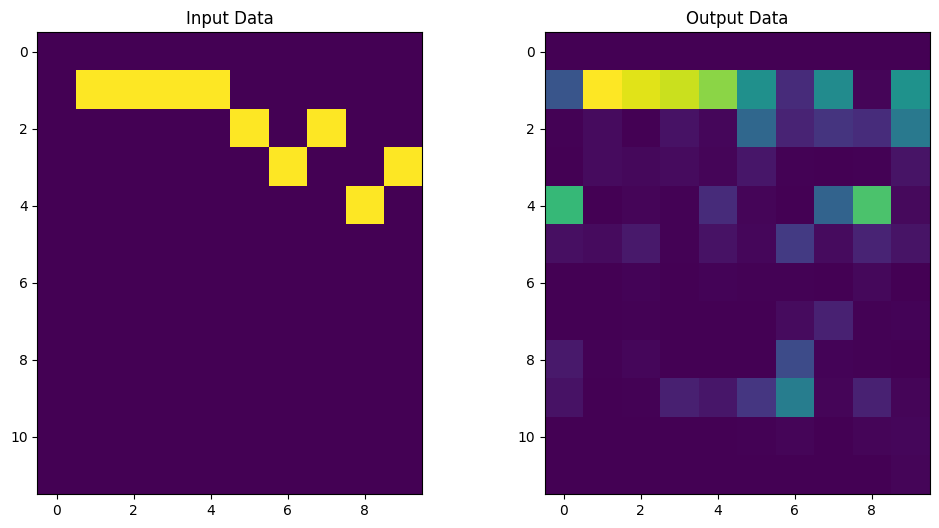


Window 20:



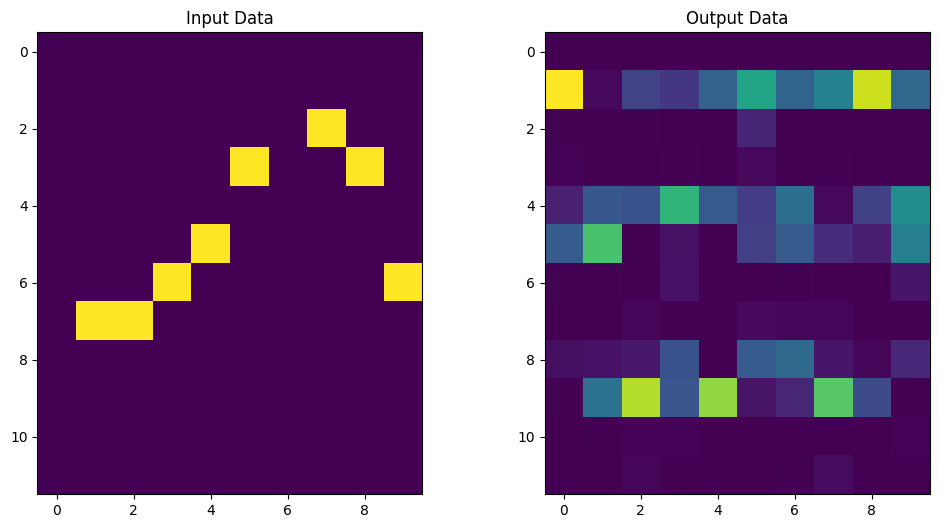


Window 21:



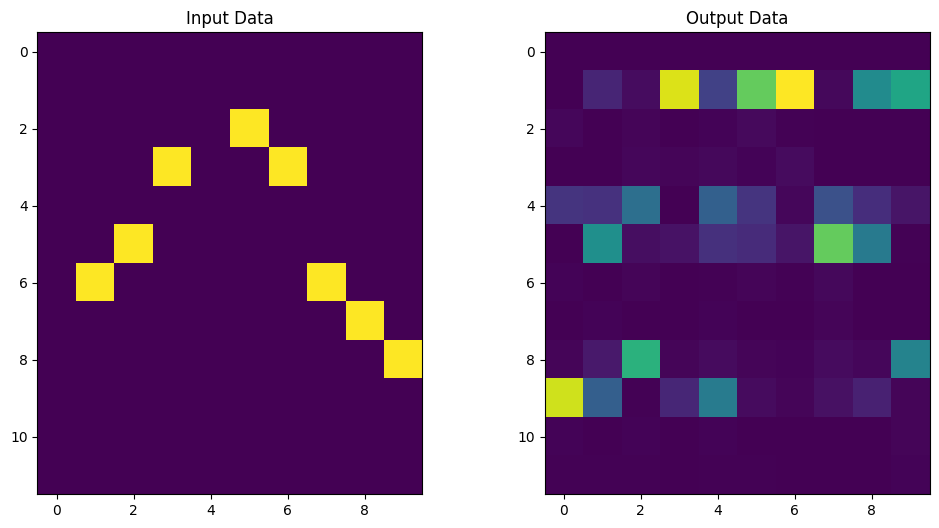


Window 22:



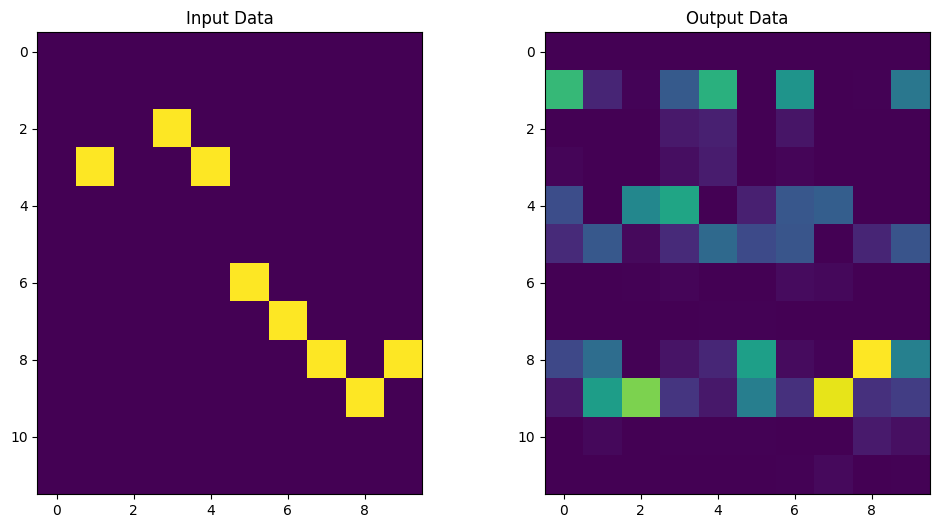


Window 23:



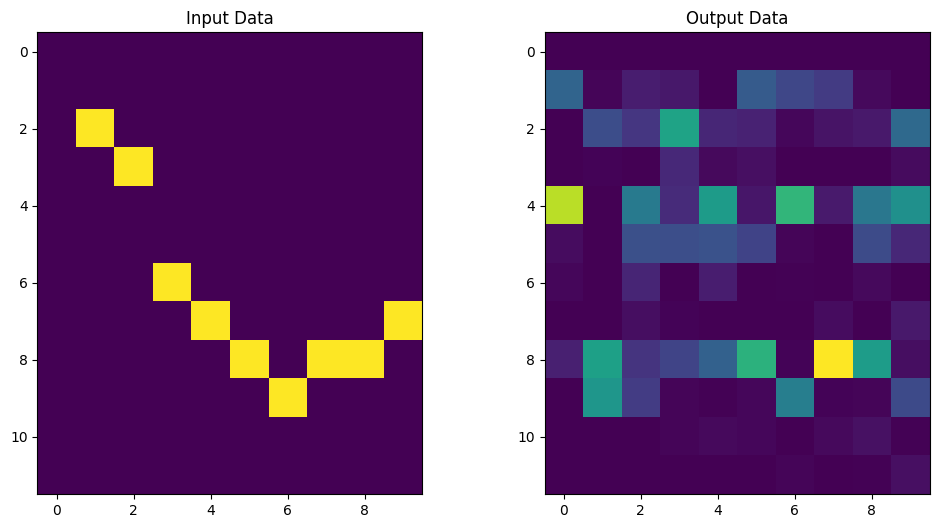


Window 30:



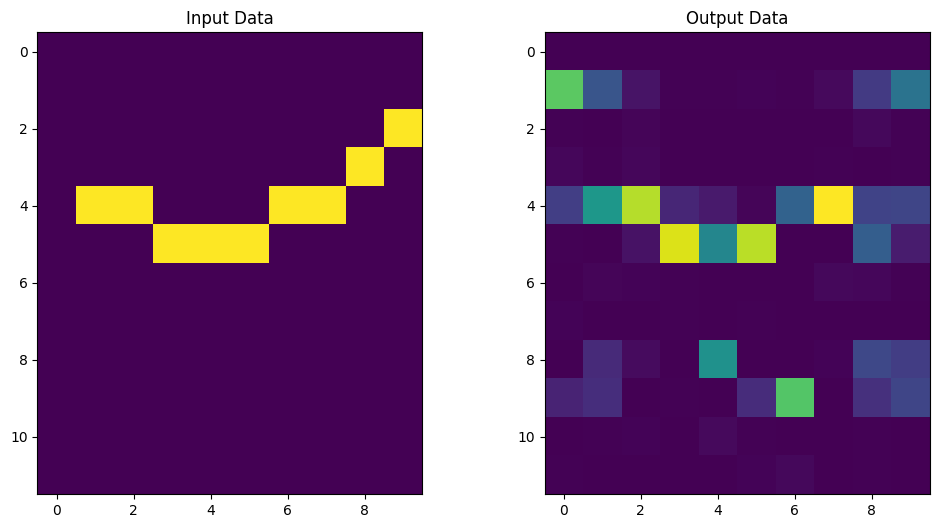

In [41]:
from qiskit.visualization import plot_histogram, plot_state_city, plot_state_paulivec

### Select a collection of windows to test
sel_wind_set = [1, 2, 3, 4, 5, 10, 20, 21, 22, 23, 30]
org_wd_norm = []
out_wd_norm = []

for wind_idx in range(len(sel_wind_set)):

    sel_wind = sel_wind_set[wind_idx]

    print(f'\nWindow {sel_wind}:\n')
    wind_valid_params = ts_reluna_wind2params(y_valid_enc, wind_padding)
    wind = wind_valid_params[sel_wind]
    
    ### Find its original window state vector representation
    org_qc = fm.assign_parameters(wind)
    org_sv = Statevector(org_qc)
    org_svd = np.abs(org_sv.data)**2
    org_wd = ts_reluna_params2wind([org_svd], wind_padding)[0]
    org_wd_norm.append((ts_reluna_norm(np.array([org_wd]))[0]).transpose())

    if sel_wind == sel_wind_set[0]:
        print(f'\n\nInput SV data (sum={np.round(np.sum(org_svd), 3)}, max={np.round(np.max(org_svd), 3)}'+
              f' at index={org_svd.argmax(axis=0)}, shape={org_wd.shape}):'+
              f'\n{np.array([[round(ww, 3) for ww in w] for w in org_wd_norm[wind_idx]])}\n')
    
    ### Find its resulting window state vector representation
    param_values = np.concatenate((wind, opt_result.x))
    out_qc = test_qc.assign_parameters(param_values)
    out_sv = Statevector(out_qc).data
    out_svd = np.abs(out_sv)**2
    out_wd = ts_reluna_params2wind([out_svd], wind_padding)[0]
    out_wd_norm.append((ts_reluna_norm(np.array([out_wd]))[0]).transpose())

    if sel_wind == sel_wind_set[0]:
        print(f'Output SV data (sum={np.round(np.sum(out_svd), 3)}, max={np.round(np.max(out_svd), 3)}'+
              f' at index={out_svd.argmax(axis=0)}, shape={out_wd.shape}):'+
              f'\n{np.array([[round(ww, 3) for ww in w] for w in out_wd_norm[wind_idx]])}\n')
    
    ### Visualise the selected results
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(org_wd_norm[wind_idx])
    ax1.set_title("Input Data")
    ax2.imshow(out_wd_norm[wind_idx])
    ax2.set_title("Output Data")
    plt.show()

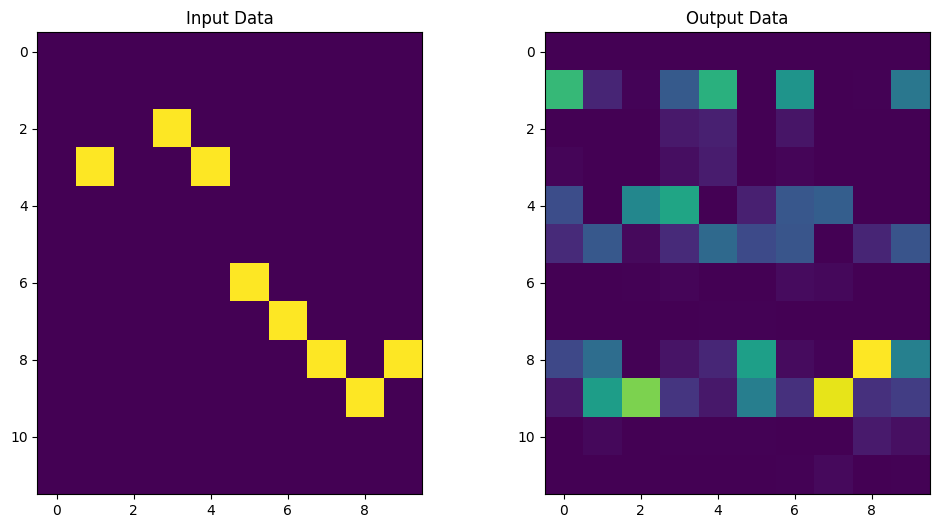

In [42]:
# sel_wind_set = [1, 2, 3, 4, 5, 10, 20, 21, 22, 23, 30]
wind_idx = 8

### Visualise the selected results
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(org_wd_norm[wind_idx])
ax1.set_title("Input Data")
ax2.imshow(out_wd_norm[wind_idx])
ax2.set_title("Output Data")
plt.show()

**<font color='red'>Unfortunately, there is little alignment between input and output state vectors.<br>
                    In this simpler TS encoding, as a series of unnary numbers, we can see some correlation!</font>**<br>

## References

1. A wikipedia page on Autoencoder: https://en.wikipedia.org/wiki/Autoencoder

2. Romero, Jonathan, Jonathan P. Olson, and Alan Aspuru-Guzik. "Quantum autoencoders for efficient compression of quantum data." Quantum Science and Technology 2.4 (2017): 045001.

3. Swap Test Algorithm: https://en.wikipedia.org/wiki/Swap_test

## Logs

**Qiskit QAE with Unary Encoding**
- V1 Using QAE for anomaly detection (by denoising)
    - V1.1 Tested binary encoding, which misses proximity
    - V2.0 Created an "unary" encoding scheme
    - V2.1 Unary encoding tested with various options, not close
      - Issues noted:
          - **Issue 01** *Not sure how to interpret the output - cannot be visual*
          - **Issue 02** *Visual match between input and output not close*
          - **Issue 03** *Noise needs to be injected in training*
          - **Issue 04** *Training is getting slow, need to use GPU*
          - **Issue 05** *It is worth testing if an increase of the latent layer could improve the result*
      - Action planned:
          - *Add Aer GPU*, *Add noise in training*, *Add convolution*, *Create classical solution to compare*
    - V2.2: Adding GPU plus encoding test
      - Encoding test:
          - Tested amplitude encoding. To improve the QAE we may need to focus on other aspects of the model,
            e.g. incorporation of noise and improvement to the ansatz to ensure neighbourhoods are strongly
            entangled.
      - Several problems installing GPU support, attempt to address **Issue 04**
          - **Issue 06** *Several problems associated with GPU support*<br/>
          - **Suggested Fix 06** *Need to install ML 0.7+ and Aer 0.13+ (possibly from source)*<br/>
            ML 0.7.1 standard installation (no need to install from source anymore)<br/>
            Aer 0.13.2 requires CUDA + cuQuantum + cuTensor (Deb), refer to ironfrown discussion on Slack,
              with detailed procedure explained on Google Collab, see:<br/>
            - https://colab.research.google.com/drive/1mLEYEPzBJTJmCDRjFJ9tHuacYu15c0hY?usp=sharing#scrollTo=BiCGqpoKeblN
            - Note that Aer Sampler has a bug dealing with RawFeatureVector feature map and cannot
              instantiate it properly, thus causing error in circuit transpilation.
              To workaround would be to use PyTorch and create own circuit optimisation loop,
              which separates input instantiation from parameter optimisation.<br/>
            - The bug still persist in ML 0.7.1 and Aer 0.13.2, problems with Sampler implementation

In [43]:
!pip list | grep -e qiskit -e torch -e tensorflow -e PennyLane

qiskit                        0.45.2
qiskit-aer-gpu                0.13.2
qiskit-algorithms             0.2.2
qiskit-dynamics               0.4.3
qiskit-finance                0.4.0
qiskit-ibm-provider           0.6.3
qiskit-ibm-runtime            0.11.3
qiskit-ibmq-provider          0.20.2
qiskit-machine-learning       0.7.1
qiskit-nature                 0.7.1
qiskit-optimization           0.6.0
qiskit-qasm3-import           0.4.1
qiskit-sphinx-theme           1.12.1
qiskit-terra                  0.45.2
torch                         2.1.0
torchaudio                    2.1.0
torchsummary                  1.5.1
torchvision                   0.16.0


In [45]:
import qiskit.tools.jupyter

# Note that Qiskit Terra and ML were compiled in from sources
%qiskit_version_table

# As this code was derived from Qiskit tutorial retain the following
%qiskit_copyright